In [1]:
import cv2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.nonparametric import smoothers_lowess as slow

In [2]:
path=''
name='Example-of-tree-cores-collected-with-a-5-mm-increment-borer_W640'

initialrun=1

img = cv2.imread(path+name+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

qalb=[[25, 85], [640, 84]]
jvir_heart=[[87, 163], [505, 166]]
jvir_young=[[515, 163], [640, 166]]
pech=[[90, 253], [600, 240]]
ptae=[[18, 333], [640, 319]]
ltul=[[36, 412], [640, 405]]

points=qalb+jvir_heart+jvir_young+pech+ptae+ltul

win_size=6

print('length: '+str(len(img))+'   width: '+str(len(img[0])))

length: 449   width: 640


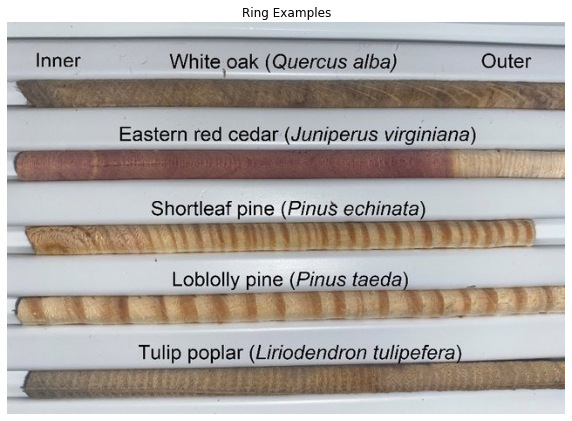

In [3]:
#Plot results
fig1=plt.figure(figsize=(10, 12))
fig1=plt.imshow(img)
fig1=plt.xscale('linear')
fig1=plt.axis('off')
fig1=plt.title('Ring Examples')
plt.show(fig1)

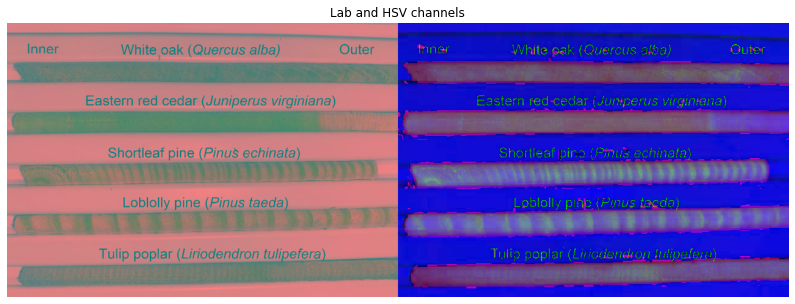

In [4]:
lab_img=cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
hsv_img=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

channels_merged=cv2.hconcat((lab_img, hsv_img))

fig1=plt.figure(figsize=(14, 20))
fig1=plt.imshow(channels_merged)
fig1=plt.xscale('linear')
fig1=plt.axis('off')
fig1=plt.title('Lab and HSV channels')
plt.show(fig1)

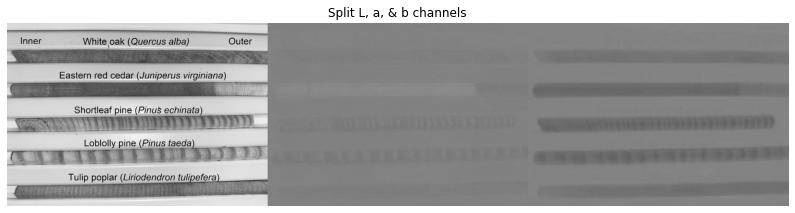

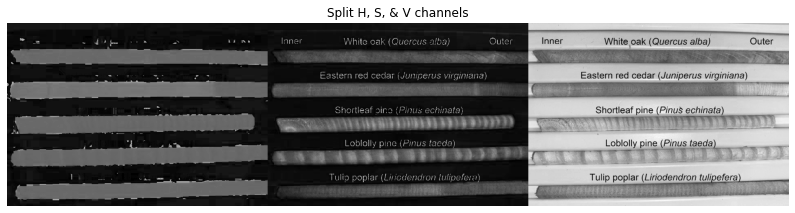

In [5]:
l, a, b = cv2.split(lab_img)
h, s, v = cv2.split(hsv_img)

lab_channels = cv2.hconcat((l, a, b))
hsv_channels = cv2.hconcat((h, s, v))

fig1=plt.figure(figsize=(14, 30))
fig1=plt.imshow(lab_channels, 'gray')
fig1=plt.xscale('linear')
fig1=plt.axis('off')
fig1=plt.title('Split L, a, & b channels')

fig2=plt.figure(figsize=(14, 30))
fig2=plt.imshow(hsv_channels, 'gray')
fig2=plt.xscale('linear')
fig2=plt.axis('off')
fig2=plt.title('Split H, S, & V channels')

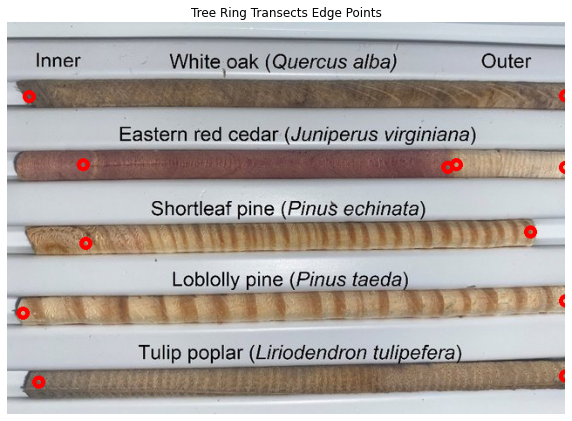

In [6]:
lfit_col='#%02x%02x%02x' % (125, 180, 255)

new_img=img.copy()

for p in range(len(points)):
    cp=points[p]
    new_img=cv2.circle(new_img, (cp[0], cp[1]), radius=5, color=(255,0,0), thickness=3)

fig1=plt.figure(figsize=(10, 12))
fig1=plt.imshow(new_img, 'gray')
fig1=plt.xscale('linear')
fig1=plt.axis('off')
fig1=plt.title('Tree Ring Transects Edge Points')


In [58]:
#Specify current species abbreviation 
#Options are: 'qalb', 'jvir', 'pech', 'ptae', 'ltul'
spp=ptae.copy()

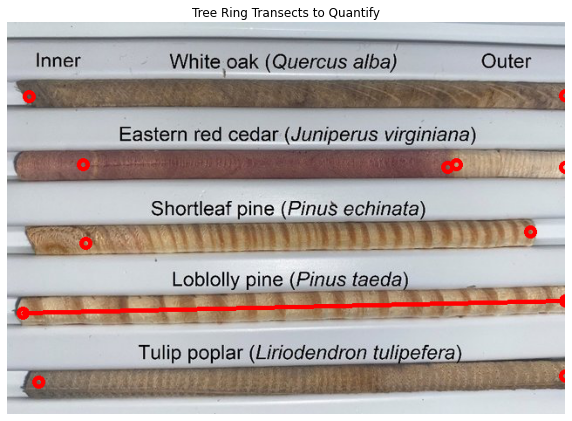

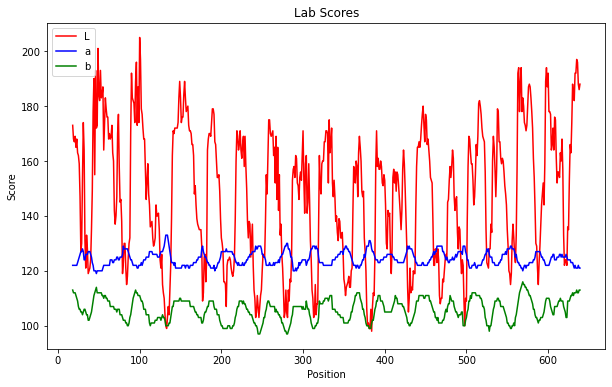

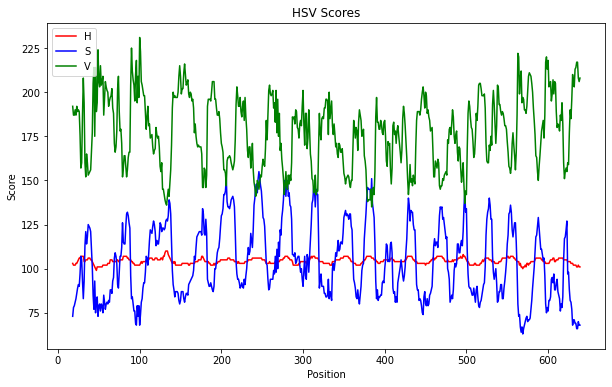

In [59]:
new_img=img.copy()

for p in range(len(points)):
    cp=points[p]
    new_img=cv2.circle(new_img, (cp[0], cp[1]), radius=5, color=(255,0,0), thickness=3)

cv2.line(new_img, (spp[0][0], spp[0][1]), (spp[1][0], spp[1][1]), color=(255,0,0), thickness=3)

fig1=plt.figure(figsize=(10, 12))
fig1=plt.imshow(new_img, 'gray')
fig1=plt.xscale('linear')
fig1=plt.axis('off')
fig1=plt.title('Tree Ring Transects to Quantify')

lm=stats.linregress([spp[0][0], spp[1][0]], [spp[0][1], spp[1][1]])
lm_a=lm[0]; lm_b=lm[1];

x_fit=range(0, 639, 1)
y_fit=np.round(lm_a*x_fit+lm_b)

l_scores=[]; a_scores=[]; b_scores=[];
h_scores=[]; s_scores=[]; v_scores=[];
signal=[]

x_fit=range(spp[0][0], spp[1][0], 1)

for i in range(len(x_fit)): #J value provides a the transect position to scan across for pixel intensities
    l_val=[]; a_val=[]; b_val=[]; h_val=[]; s_val=[]; v_val=[];
    for j in range(-(win_size-1),win_size): #J value provides a window on either side of the transect position 
        z=i+j                               #to average pixel intensities across the current position
        if(min(x_fit) > z): #Sanity check to ensure the window can exceed the bounds of x_fit
            z=0
        if(max(x_fit) < z): #Sanity check to ensure the window can exceed the bounds of x_fit
            z=max(x_fit)
            
        l_val.append(l[int(y_fit[z]),int(x_fit[i])])
        a_val.append(a[int(y_fit[z]),int(x_fit[i])])
        b_val.append(b[int(y_fit[z]),int(x_fit[i])])

        h_val.append(h[int(y_fit[z]),int(x_fit[i])])
        s_val.append(s[int(y_fit[z]),int(x_fit[i])])
        v_val.append(v[int(y_fit[z]),int(x_fit[i])])
        
    l_val=int(np.mean(l_val)); a_val=int(np.mean(a_val)); b_val=int(np.mean(b_val));
    h_val=int(np.mean(h_val)); s_val=int(np.mean(s_val)); v_val=int(np.mean(v_val));
    
    l_scores.append(l_val); a_scores.append(a_val); b_scores.append(b_val);
    h_scores.append(h_val); s_scores.append(s_val); v_scores.append(v_val);
    signal.append(np.round(((l_val-b_val)))/255)
    
if initialrun==1:       
    fig2=plt.figure(figsize=(10, 6))
    fig2=plt.plot(x_fit, l_scores, color='red', label='L')
    fig2=plt.plot(x_fit, a_scores, color='blue', label='a')
    fig2=plt.plot(x_fit, b_scores, color='green', label='b')
    fig2=plt.legend(loc="upper left")
    fig2=plt.xscale('linear')
    fig2=plt.xlabel('Position')
    fig2=plt.ylabel('Score')
    fig2=plt.title('Lab Scores')

    fig3=plt.figure(figsize=(10, 6))
    fig3=plt.plot(x_fit, h_scores, color='red', label='H')
    fig3=plt.plot(x_fit, s_scores, color='blue', label='S')
    fig3=plt.plot(x_fit, v_scores, color='green', label='V')
    fig3=plt.legend(loc="upper left")
    fig3=plt.xscale('linear')
    fig3=plt.xlabel('Position')
    fig3=plt.ylabel('Score')
    fig3=plt.title('HSV Scores')

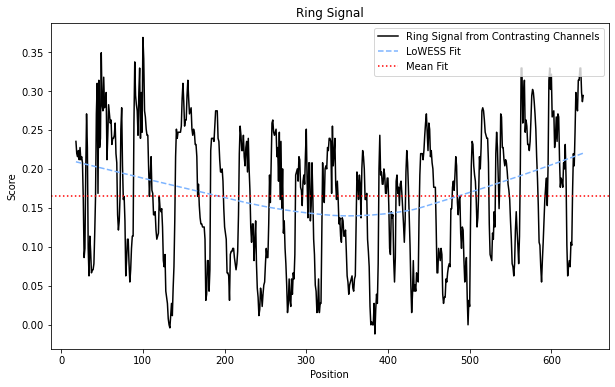

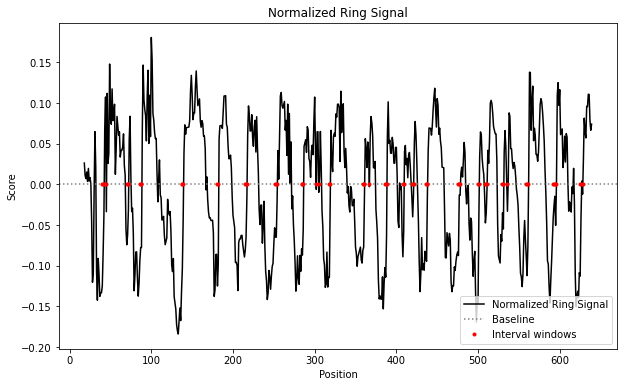

In [60]:
lowess_fit=slow.lowess(np.array(signal), np.array(x_fit), it=3, delta=7)
lowess_fit

lx_fit=[]; ly_fit=[];
for i in range(len(lowess_fit)):
    lx_fit.append(lowess_fit[i][0])
    ly_fit.append(lowess_fit[i][1])

fig4=plt.figure(figsize=(10, 6))
fig4=plt.plot(x_fit, signal, color='black', label='Ring Signal from Contrasting Channels')
fig4=plt.plot(lx_fit, ly_fit, color=lfit_col, ls='--', label='LoWESS Fit')
fig4=plt.axhline(np.mean(signal), ls=':', color='red', label='Mean Fit')
fig4=plt.legend(loc="upper right")
fig4=plt.xscale('linear')
fig4=plt.xlabel('Position')
fig4=plt.ylabel('Score')
fig4=plt.title('Ring Signal')

n_signal=[]
for i in range(len(signal)):
    n_signal.append(signal[i]-ly_fit[i])

intervals=[]; n_x=[];
for i in range(len(n_signal)-5):
    current=n_signal[i]
    trend=np.mean([n_signal[i+1],n_signal[i+2],n_signal[i+3],n_signal[i+4],n_signal[i+5]])
    if (current<0 and trend>=0):
        n_x.append(i)
        intervals.append(x_fit[i])
        #print(current, trend)
        
fig5=plt.figure(figsize=(10, 6))
fig5=plt.plot(x_fit, n_signal, color='black', label='Normalized Ring Signal')
fig5=plt.axhline(0, ls=':', color='gray', label='Baseline')
fig5=plt.plot(intervals, [0]*len(intervals), marker='.', ls='', color='red', label='Interval windows')
fig5=plt.legend(loc="lower right")
fig5=plt.xscale('linear')
fig5=plt.xlabel('Position')
fig5=plt.ylabel('Score')
fig5=plt.title('Normalized Ring Signal')

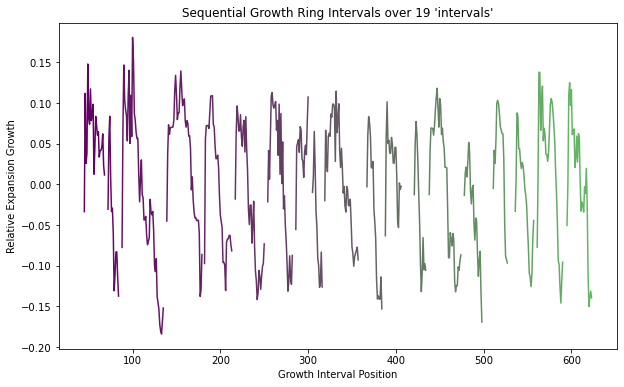

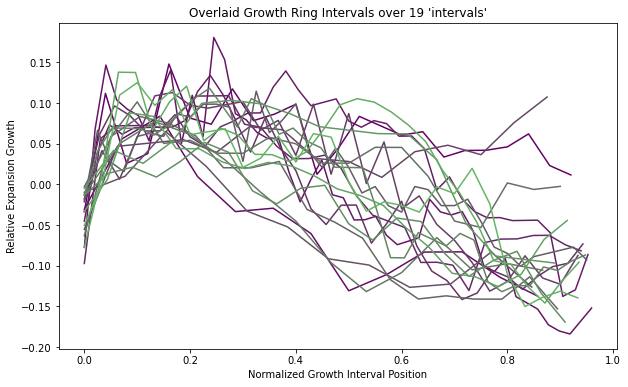

In [66]:
seasons=0

fig1=plt.figure(figsize=(10, 6))

for i in range(len(n_x)-1):
   
    start=n_x[i]
    stop=n_x[i+1]
    
    if start+10<stop:
        
        intervalcol= '#%02x%02x%02x' % (100, 1+(seasons*10), 100)
        seasons=seasons+1
        
        win_pos=range(start, stop)
        pos=range(x_fit[start], x_fit[stop])
        
        x_interval_sequence=[]; x_interval_overlay=[]; y_interval=[];
        
        for j in range(len(win_pos)-1):
            x_interval_sequence.append(pos[j])
            x_interval_overlay.append(j/len(win_pos))   #win_pos[j]/max(win_pos)
            y_interval.append(n_signal[win_pos[j]])
        fig1=plt.plot(x_interval_sequence, y_interval, color=intervalcol, label='Normalized Ring Signal')

fig1=plt.xscale('linear')
fig1=plt.xlabel('Growth Interval Position')    
fig1=plt.ylabel('Relative Expansion Growth')
fig1=plt.title('Sequential Growth Ring Intervals over '+str(seasons)+' \'intervals\'')      

seasons=0

fig2=plt.figure(figsize=(10, 6))

position=[]; relative_position=[];
growth=[]; growth_interval=[];

for i in range(len(n_x)-1):
   
    start=n_x[i]
    stop=n_x[i+1]
    
    if start+10<stop:
        
        intervalcol= '#%02x%02x%02x' % (100, 1+(seasons*10), 100)
        seasons=seasons+1
        
        win_pos=range(start, stop)
        pos=range(x_fit[start], x_fit[stop])
        
        x_interval_sequence=[]; x_interval_overlay=[]; y_interval=[];

        for j in range(len(win_pos)-1):
            position.append(pos[j]); relative_position.append(j/len(win_pos));
            growth.append(n_signal[win_pos[j]]); growth_interval.append(seasons);
            
            x_interval_sequence.append(position[-1])
            x_interval_overlay.append(relative_position[-1])   #win_pos[j]/max(win_pos)
            y_interval.append(growth[-1])
        fig1=plt.plot(x_interval_overlay, y_interval, color=intervalcol, label='Normalized Ring Signal')
        
fig2=plt.xscale('linear')
fig2=plt.xlabel('Normalized Growth Interval Position')
fig2=plt.ylabel('Relative Expansion Growth')
fig2=plt.title('Overlaid Growth Ring Intervals over '+str(seasons)+' \'intervals\'') 



In [71]:
#Store data in a Pandas DF for exporting possibility
ringgrowth=[growth_interval, position, relative_position, growth]
ringgrowth=pd.DataFrame(ringgrowth)
ringgrowth=ringgrowth.T
ringgrowth.columns = ['Growth Interval', 'Position', 'Relative Position in Interval', 'Colorimetric Growth Intensity']
ringgrowth.head()


,Growth Interval,Position,Relative Position in Interval,Colorimetric Growth Intensity
0,1.0,45.0,0.00,-0.033547
1,1.0,46.0,0.04,0.111809
2,1.0,47.0,0.08,0.025791
3,1.0,48.0,0.12,0.037813
4,1.0,49.0,0.16,0.147874


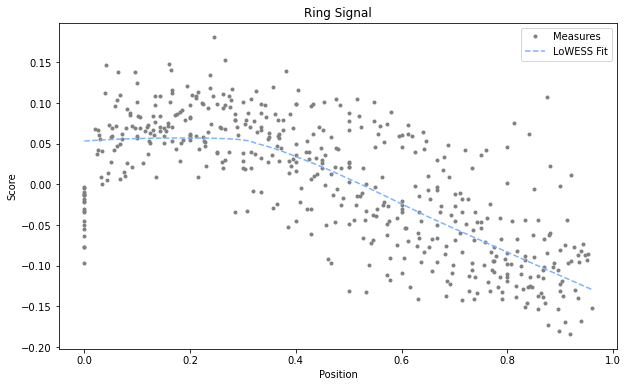

In [72]:
lowess_growth=slow.lowess(np.array(ringgrowth['Colorimetric Growth Intensity']), np.array(ringgrowth['Relative Position in Interval']), it=10, delta=0.0025)
lowess_growth

lx_g=[]; ly_g=[];
for i in range(len(lowess_growth)):
    lx_g.append(lowess_growth[i][0])
    ly_g.append(lowess_growth[i][1])
    
fig1=plt.figure(figsize=(10, 6))
fig5=plt.plot(relative_position, growth, marker='.', ls='', color='gray', label='Measures')
fig4=plt.plot(lx_g, ly_g, color=lfit_col, ls='--', label='LoWESS Fit')
fig4=plt.legend(loc="upper right")
fig4=plt.xscale('linear')
fig4=plt.xlabel('Position')
fig4=plt.ylabel('Score')
fig4=plt.title('Ring Signal')